<a href="https://colab.research.google.com/github/LightGreenWorld/Proj_NLP_Kobert/blob/main/Grammatical_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, SequentialSampler, RandomSampler, random_split

if torch.cuda.is_available(): # GPU 이용 가능하다면,
  device = torch.device("cuda")   # 파이토치에게 GPU("cuda") 사용하라고 말해; CUDA(Computed Unified Device Architecture)
  print("There are %d GPU(s) available." % torch.cuda.device_count())
  print("We will use the GPU:", torch.cuda.get_device_name(0))  # GPU 장치 이름 출력

elif torch.backends.mps.is_built() & torch.backends.mps.is_available():
  print(f"MPS 장치를 지원하도록 build가 되었는가? {torch.backends.mps.is_built()}")
  print(f"MPS 장치가 사용 가능한가? {torch.backends.mps.is_available()}")
  device = torch.device("mps")

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")    # GPU가 없다면/GPU를 이용할 수 없다면 파이토치에게 CPU("cpu") 사용하라고 말해줘

MPS 장치를 지원하도록 build가 되었는가? True
MPS 장치가 사용 가능한가? True


In [ ]:
import pandas as pd # tsv파일 열기 위한 라이브러리

# Train(훈련) / Dev(검증) / Test(테스트) dataset
dataset_train = pd.read_csv("/opt/anaconda3/envs/LLM_gramKo/dataset/NIKL_CoLA_train.tsv", delimiter = '\t', header=None, names = ['sentence_source_train', 'label_train', 'label_notes', 'sentence_train'])
dataset_dev = pd.read_csv("/opt/anaconda3/envs/LLM_gramKo/dataset/NIKL_CoLA_dev.tsv", delimiter = '\t', header = None, names = ['sentence_source_dev', 'label_dev', 'lable_notes_dev', 'sentence_dev'])
dataset_test = pd.read_csv("/opt/anaconda3/envs/LLM_gramKo/dataset/NIKL_CoLA_test.tsv", delimiter = '\t', header = None, names = ['index', 'sentence_test'])

# 문장 개수 확인
print("Number of training sentence: {:,}\n".format(dataset_train.shape[0]))
print("Number of dev sentence: {:,}\n".format(dataset_dev.shape[0]))
print("Number of test sentence: {:,}\n".format(dataset_test.shape[0]))

# To check the table frame
print(f' train: {dataset_train.head(10)}')
print(f' test: {dataset_test.head(10)}')

# 랜덤으로 10개 문장 확인
# dataset_train.sample(10)
# dataset_dev.sample(10)
# dataset_test.sample(10)

Number of training sentence: 15,877

Number of dev sentence: 2,033

Number of test sentence: 1,061

 train:   sentence_source_train          label_train        label_notes  \
0                source  acceptability_label  source_annotation   
1                T00001                    1                NaN   
2                T00001                    0                  *   
3                T00002                    1                NaN   
4                T00003                    1                NaN   
5                T00004                    1                NaN   
6                T00004                    0                  *   
7                T00005                    1                NaN   
8                T00005                    0                  ?   
9                T00006                    1                NaN   

    sentence_train  
0         sentence  
1        높은 달이 떴다.  
2       달이 뜸이 높았다.  
3  실없는 사람이 까불까불한다.  
4  나는 철수에게 공을 던졌다.  
5  내가 순이와 둘이서 다툰다.  
6  내가 순

## Process to train Model

### Pre-processing of Dataset_train & _dev & _test 전처리

In [ ]:
# 데이터 전처리
import numpy as np

# to convert each column of train data to list excluding column's name and index
sentences_train = dataset_train.sentence_train.values[1:]
labels_train = dataset_train.label_train.values[1:].astype(np.int64)
#print("Train_sentences: ", sentences_train)
#print("Train_labels: ", labels_train)

# to convert each column of dev data to list excluding column's name and index
sentences_dev = dataset_dev.sentence_dev.values[1:]
labels_dev = dataset_dev.label_dev.values[1:].astype(np.int64) # To change to integer
#print("Dev_sentences: ", sentences_dev)
#print("Dev_labels: ", labels_dev)

# to convert each column of test data to list excluding column's name and index
sentences_test = dataset_test.sentence_test.values[1:]
index_test = dataset_test.index.values[1:].astype(np.int64) # To change to integer
#print("Test_sentences: ", sentences_test)
#print("Test_index: ", index_test)

# to convert the whole columns of train/dev/test data to list excluding column's name and index
dataset_train = dataset_train.values[1:]
dataset_dev = dataset_dev.values[1:]
dataset_test = dataset_test.values[1:]

print("--------------------------")
print(f'The whole train dataset: \n {dataset_train}')
print(f'The whole dev dataset: \n {dataset_dev}')
print(f'The whole test dataset: \n {dataset_test}')

--------------------------
The whole train dataset: 
 [['T00001' '1' nan '높은 달이 떴다.']
 ['T00001' '0' '*' '달이 뜸이 높았다.']
 ['T00002' '1' nan '실없는 사람이 까불까불한다.']
 ...
 ['T09999' '1' nan '선생님이 순희에게 책을 읽게 하시나 순희는 책을 읽지 않는다.']
 ['T09999' '0' '*' '선생님이 순희에게 책을 읽히시나 순희는 책을 읽지 않는다']
 ['T10000' '1' nan '그의 부주의로 말미암아 사건이 터졌다.']]
The whole dev dataset: 
 [['T00002' '0' '*' '실없는 사람이 까불한다.']
 ['T00029' '1' nan '순희에게는 아무리 좋은 옷도 어울리지 않는다.']
 ['T00033' '0' '*' '사람은 언제나 젊는 수는 없다.']
 ...
 ['T09994' '0' '*' '밤새 그 술을 다 먹었는 것이다.']
 ['T09997' '1' nan '학교에서 철수는 놀았고, 순이는 공부했다.']
 ['T10000' '0' '*' '그의 부주의에 말미암아 사건이 터졌다.']]
The whole test dataset: 
 [['0' '나는 철수에게 공을 던져다 주었다.']
 ['1' '먹은 것을 다 소화시켜야 한다.']
 ['2' '그가 노래를 부르고는 내가 피아노를 쳤다.']
 ...
 ['1057' '그는 나를 바보 여긴다.']
 ['1058' '수호는 모든 일에 전혀 무감각하다.']
 ['1059' '나는 할아버지가 제일 무서우시다.']]


### SKT-Kobert 인스톨

In [ ]:
!pip install kobert-transformers
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

from transformers import BertTokenizer

#KoBert
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

  Cloning https://github.com/SKTBrain/KoBERT.git to /private/var/folders/b2/zwc3jd5d6wn09h5jtpfzqcqc0000gn/T/pip-install-a464q4dm/kobert-tokenizer_74ad72768b824450a895fc4561d3c458
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /private/var/folders/b2/zwc3jd5d6wn09h5jtpfzqcqc0000gn/T/pip-install-a464q4dm/kobert-tokenizer_74ad72768b824450a895fc4561d3c458
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


### 데이터 토크나이저

In [ ]:
# 샘플 데이터로 토크나이저 잘 되나 확인
print("Train_Original: ", sentences_train[0])
print("Train_Tokenized: ", tokenizer.tokenize(sentences_train[0]))
print("Train_Token IDs: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_train[0])))

print("Dev_Original: ", sentences_dev[0])
print("Dev_Tokenized: ", tokenizer.tokenize(sentences_dev[0]))
print("Dev_Token IDs: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_dev[0])))

Train_Original:  높은 달이 떴다.
Train_Tokenized:  ['▁높은', '▁달', '이', '▁', '떴', '다', '.']
Train_Token IDs:  [1520, 1597, 7096, 517, 5974, 5782, 54]
Dev_Original:  실없는 사람이 까불한다.
Dev_Tokenized:  ['▁실', '없는', '▁사람이', '▁', '까', '불', '한다', '.']
Dev_Token IDs:  [3036, 6882, 2589, 517, 5591, 6424, 7831, 54]


In [ ]:
# To check max length of tokenized sentences

def find_sentence_with_most_tokens(sentences):
    # Initialize the sentence with the most tokens and the maximum token count
    resultsentence = ""
    maxtokens = 0

    for singlesent in sentences:
        tokens = tokenizer.tokenize(singlesent)
        numtokens = len(tokens)

        # Update if the current sentence has more tokens
        if numtokens > maxtokens:
            resultsentence = singlesent
            maxtokens = numtokens

    return resultsentence, maxtokens

result_sentence_train, max_tokens_train = find_sentence_with_most_tokens(sentences_train)
result_sentence_dev, max_tokens_dev = find_sentence_with_most_tokens(sentences_dev)
result_sentence_test, max_tokens_test = find_sentence_with_most_tokens(sentences_test)

print(f'Train - Max Tokens: {max_tokens_train}, Corresponding sentence: {result_sentence_train}')
print(f'Dev - Max Tokens: {max_tokens_dev}, Corresponding sentence: {result_sentence_dev}')
print(f'Test - Max Tokens: {max_tokens_test}, Corresponding sentence: {result_sentence_test}')

Train - Max Tokens: 36, Corresponding sentence: 이 기간 중 투자율은 25.2퍼센트에 달하여 계획치를 크게 상회하였으나, 국내 저축률은 계획치를 약간 상회하였다.
Dev - Max Tokens: 33, Corresponding sentence: 철수는 영희가 몇 명의 학생을 가르쳤다고 예은이에게 말했니, 세 명 가르쳤다고 예은이에게 말했니?
Test - Max Tokens: 28, Corresponding sentence: 마르고 유약해 보이는 용모를 가진 한 남자 가수가 분장실 바닥에 쭈그리면서 앉아 있다.


### Dataset_train & _Dev 의 encoded_dict

In [ ]:
# Training dataset
# 모든 문장을 토크나이즈 한 후 토큰들을 그것들의 단어 ID에 대응·매치시키는 작업

input_ids_train = []
attention_masks_train = []

# 모든 문장에 대하여
for sent in sentences_train:
    # `encode_plus`는:
    #   (1) 문장을 토크나이저.
    #   (2) [CLS]를 모든 문장의 가장 앞에 삽입.
    #   (3) [SEP]을 모든 문장의 가장 뒤에 삽입.
    #       CLS, SEP는 토큰 임베딩 분야의 특수 토큰으로,
    #       CLS는 special CLaSsification token, SEP은 sepcial SEParator token을 의미
    #   (4) 토큰들을 그들의 단어 아이디와 매치시킴.
    #   (5) 문장의 길이는 'max_length' 수치에 맞게 늘려주거나 줄여줌.
    #       Pad: 특정 형상의 배열로 변형할 때 빈자리를 0으로 채워준다는 의미
    #   (6) [PAD] 토큰을 위한 attention mask 생성
    encoded_dict = tokenizer.encode_plus(
                        sent,                         # 인코딩할 문장 자리 / 문장을 인코딩
                        add_special_tokens = True,    # 특수 토큰 [CLS]와 [SEP] 추가
                        max_length = 40,              # max_length에 맞게 모든 문장 패딩 & 축소
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True, # Attention Mask 구축 / 자료 구조는 tensor 형태
                                                      # Attention Mask는 단어 배치와 동일하게 "1" 생성
                        return_tensors = 'pt',        # 인코딩된 문장을 pytorch 텐서 형태로 변경
                                                      # tensorflow를 사용하고 있다면 return_tensors = 'tf'라고 씀
                   )

    # 인코딩된 문장들을 글로벌 선언한 List [input_ids_train]에 넣기
    input_ids_train.append(encoded_dict['input_ids'])

    # Attention mask 인자들 List[attention_masks_train]에 넣기 (simply differentiates padding from non-padding).
    attention_masks_train.append(encoded_dict['attention_mask'])

# 리스트를 텐서 형태로 변경
input_ids_train = torch.cat(input_ids_train, dim=0) # dim은 축·차원의 수 axis0부터 시작, dim=0는 축 1개 or 1차원
attention_masks_train = torch.cat(attention_masks_train, dim=0)
labels_train = torch.tensor(labels_train)

# 0번째 문장, 토큰, 라벨 아이디 출력 (인코딩이 잘 됐는지 확인하는 작업)
print(f'Train_Original: {sentences_train[0]}') # 1차원
print(f'Train_Token IDs: {input_ids_train},\nTrain_input_ids_shape: {input_ids_train.shape}, \nTrain_input_ids_dim: {input_ids_train.ndim}')
print(f'Train_labels: {labels_train}, \nTrain_labels_shape: {labels_train.shape}, \nTrain_labels_dim: {labels_train.ndim}')

Train_Original: 높은 달이 떴다.
Train_Token IDs: tensor([[   2, 1520, 1597,  ...,    1,    1,    1],
        [   2, 1597, 7096,  ...,    1,    1,    1],
        [   2, 3036, 6882,  ...,    1,    1,    1],
        ...,
        [   2, 2752, 7096,  ...,    1,    1,    1],
        [   2, 2752, 7096,  ...,    1,    1,    1],
        [   2, 1214, 2423,  ...,    1,    1,    1]]),
Train_input_ids_shape: torch.Size([15876, 40]), 
Train_input_ids_dim: 2
Train_labels: tensor([1, 0, 1,  ..., 1, 0, 1]), 
Train_labels_shape: torch.Size([15876]), 
Train_labels_dim: 1


In [ ]:
# Development_dataset
input_ids_dev = []
attention_masks_dev = []

for sent in sentences_dev:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 40,
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        )

    input_ids_dev.append(encoded_dict['input_ids'])

    attention_masks_dev.append(encoded_dict['attention_mask'])

input_ids_dev = torch.cat(input_ids_dev, dim=0)
attention_masks_dev = torch.cat(attention_masks_dev, dim=0)
labels_dev = torch.tensor(labels_dev)

print(f'Dev_Original: {sentences_dev[0]}') # 1차원
print(f'Dev_Token IDs: {input_ids_dev},\nDev_input_ids_shape: {input_ids_dev.shape}, \nDev_input_ids_dim: {input_ids_dev.ndim}')
print(f'Dev_labels: {labels_dev}, \nDev_labels_shape: {labels_dev.shape}, \nDev_labels_dim: {labels_dev.ndim}')

Dev_Original: 실없는 사람이 까불한다.
Dev_Token IDs: tensor([[   2, 3036, 6882,  ...,    1,    1,    1],
        [   2, 2912, 7993,  ...,    1,    1,    1],
        [   2, 2587, 3245,  ...,    1,    1,    1],
        ...,
        [   2, 2265, 6536,  ...,    1,    1,    1],
        [   2, 4949, 6903,  ...,    1,    1,    1],
        [   2, 1214, 2423,  ...,    1,    1,    1]]),
Dev_input_ids_shape: torch.Size([2032, 40]), 
Dev_input_ids_dim: 2
Dev_labels: tensor([0, 1, 0,  ..., 0, 1, 0]), 
Dev_labels_shape: torch.Size([2032]), 
Dev_labels_dim: 1


***TensorDataset()은 텐서를 감싸는 (wrapping) Dataset으로, 길이와 인덱싱 방식을 정의<br>
Dataset을 상속한 클래스로, 학습데이터·독립변수X(input_ids_train, attention_mask_train)와 레이블·종속변수Y(labels_train)를 묶어 놓는 컨테이너<br>
TensorDataset()을 DataLoader에 전달하면, 반복문(for문)에서 데이터의 일부분만 간단히 추출할 수 있다.<br>
TensorDataset()은 텐서만 전달 가능하며, Variable은 전달 불가.<br>***

In [ ]:
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dev_dataset = TensorDataset(input_ids_dev, attention_masks_dev, labels_dev)

# 트레이닝 데이터 & 검증 데이터 크기 다시 한 번 확인
print(f'Number of train sentence: {int(len(train_dataset))}')
print(f'Number of dev sentence: {int(len(dev_dataset))}')

Number of train sentence: 15876
Number of dev sentence: 2032


In [ ]:
batch_size = 32

# Train Dataloader 생성
train_dataloader = DataLoader(
                              train_dataset, # Train samples.
                              sampler = RandomSampler(train_dataset),
                              batch_size = batch_size)

# Dev Dataloader 생성
dev_dataloader = DataLoader(
                            dev_dataset, # Dev samples.
                            sampler = RandomSampler(dev_dataset),
                            batch_size = batch_size)

print(len(train_dataloader))
print(len(dev_dataloader))

497
64


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# BertForSequenceClassification 설치
# 가장 위 레이어에 단일 linear classification 레이어를 가진, 사전 학습된 BERT 모델
model = BertForSequenceClassification.from_pretrained(
    'skt/kobert-base-v1',
    num_labels = 2, # 레이블의 개수는 2진분류가 디폴트.
                    # 하지만 멀티 클래스 태스크를 증가시킬 수 있다(?)
    output_attentions = False,
    output_hidden_states = False,
)

# Pytorch에게 이 모델을 GPU/MPS에서 사용하라고 요청
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at skt/kobert-base-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

In [ ]:
# 튜플들의 리스트 형태로 모델의 모든 파라미터들 추출

params = list(model.named_parameters())
print(f'The BERT model has {len(params):} different named paraeters.\n')

print('===== Embedding Layer =====\n')
for p in params [0:5]:
  print(f'{p[0]:<55} {str(tuple(p[1].size())):>12}')

print('\n==== First Transformer ====\n')
for p in params [5:21]:
  print(f'{p[0]:<55} {str(tuple(p[1].size())):>12}')

print('\n==== Output Layer ====\n')
for p in params [-4:]:
  print(f'{p[0]:<55} {str(tuple(p[1].size())):>12}')

The BERT model has 201 different named paraeters.

===== Embedding Layer =====

bert.embeddings.word_embeddings.weight                   (8002, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=2e-5,   # args.learning_rate - default is 5e-5
                  eps=1e-8 # args.adam_epsilon  - default is 1e-8
                  )

/opt/anaconda3/envs/LLM_gramKo/lib/python3.12/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# 일단 epochs 4로 해보고, 오버 피팅되면 조절
epochs = 1

# 학습 횟수·단계 설정: [batch의 개수] x [epochs의 개수]. (batch size ≠ batch의 개수)
# 학습 샘플 수와 같지 않음
total_steps = len(train_dataloader) * epochs

# Learning Rate 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# 예측 대비 레이블의 정확성 계산을 위한 함수
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten() # flatten(): to convert # dimension data form to 1 dimension data form
                                                 # argmax: to return index of maximum value; axis=0: each column, axis=1: each row
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
  '''
  Takes a time in seconds and returns a string hh:mm:ss
  '''
  # 1초 단위로 반올림
  elapsed_rounded = int(round((elapsed)))

  # 시간형태: hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

### To Train Model


In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

import random

# Set the seed value all over the place to make this reproducible. 하지만 42는 큰 의미 없는 수
seed_val = 42

random.seed(seed_val) # 생성된 난수 중 씨드값 42의 수 출력(고정)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.mps.manual_seed(seed_val)

# 학습값 손실, 검증값 손실, 검증데이터 정확성, 시간 등 여러 측정 상태 저장 및 출력
training_stats = []

# 전체 학습 시간 측정
total_t0 = time.time()

# each epoch에 대해서...
for epoch_i in range(0, epochs): # epochs = 4

    '''
    ========================================
                    Training
    ========================================
    '''

    print(f'\n======== Epoch {epoch_i + 1:} / {epochs:} ======== \nTraining...')

    # epoch 도는데 걸리는 시간 측정
    t0 = time.time()

    # each epoch에 대한 총 학습값 손실 0으로 리셋
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # print("step: {}, batch: {}".format(step, batch))

        # 40 배치씩 결과 출력
        ctime= time.time()
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.

            # elapsed = format_time(time.time() - t0)
            elapsed = format_time(ctime - t0)
            print("current time: ", format_time(ctime))

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Train_dataloader의 트레이닝 batch 해체 분석.
        # batch를 해체시킬 때, 각 tensor를 'to' 메소드를 사용하는 GPU(device = torch.device("mps"))에 복사
        # `batch` contains three pytorch tensors
        # [0]: input ids, [1]: attention masks, [2]: labels

        b_input_ids = batch[0].to(device)  # 2차원
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)     # 1차원

        # 항상 이전에 계산된 gradients들은, backward pass를 수행하기 전에 초기화하여 0으로 만들어 줘야함
        # PyTorch는 이것을 자동으로 해주지 않음.
        # 왜냐하면 RNNs을 학습시키는 동안에 gradients를 계산하는 것이 편리하기 때문에
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # 전방 전달(forward pass) 수행 (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.

        '''
        전방 전달(forward pass)은 입력부터 출력까지 값을 계산한다.
        그리고 나서 후방 전달(backward pass)은 역전파(back propagation)을 수행하는데,
        이는 끝에서 시작해서 반복적으로 연쇄 법칙을 적용해 회로 입력에 대한 모든 길에서
        그라디언트 값을 계산한다. 그라디언트 값은 회로를 통해 거꾸로 흐르는 것으로 볼 수 있다.

        순전파(forwards propagation)은 뉴럴 네트워크의 그래프를 계산하기 위해서
        중간 변수들을 순서대로 계산하고 저장한다. 즉, 입력층부터 시작해서 출력층까지 처리한다.
        역전파(back propagation)은 중간 변수와 파라미터에 대한 그래디언트(gradient)를
        반대 방향으로 계산하고 저장한다.
        '''

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs[0]
        loss = loss.float()
        # print("loss:", loss) # loss값 확인

        # 모든 batch에 대한 학습 손실값을 축적
        # 그래서 우리는 마지막에 평균 손실값을 구할 수 있다.

        # 'loss'는 단일 값을 포함한 Tensor.
        # '.item()'함수는 tensor로부터 Python 값을 리턴.
        total_train_loss += loss.item()

        # gradients를 계산하기 위해 loss에 대해 후방 전달(backward pass) 수행
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Development
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Development...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    predictions , true_labels = [], []

    # Evaluate data for one epoch
    for batch in dev_dataloader:

        # Unpack this training batch from our dataloader.
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.

        # `batch` contains three pytorch tensors:
        #  [0]: input ids, [1]: attention masks, [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            logits = outputs[0]
            logits = logits.float()

        # Accumulate the development loss.
        total_eval_loss += logits.item()

        dev_logits = outputs[1]
        # print("dev_logits: ", dev_logits) - dev_logits: 2차원, b_labels: 1차원

        # (log_)softmax 함수는 tensor 형태로 들어가야함
        # dev_logits = F.log_softmax(dev_logits, dim=1)
        # print("DIM_dev_logits: {}, dev_logits: {}".format(dev_logits.ndim, dev_logits))

        # Move logits and labels to CPU
        # argmax 함수는 numpy 형태로 들어가야함
        dev_logits = dev_logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(dev_logits, label_ids)

    # Report the final accuracy for this development run.
    avg_dev_accuracy = total_eval_accuracy / len(dev_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_dev_accuracy))

    # Calculate the average loss over all of the batches.
    avg_dev_loss = total_eval_loss / len(dev_dataloader)

    # Measure how long the validation run took.
    development_time = format_time(time.time() - t0)

    print("  Development Loss: {0:.2f}".format(avg_dev_loss))
    print("  Development took: {:}".format(development_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Loss': avg_train_loss,
            'Dev Loss': avg_dev_loss,
            'Dev Accur.': avg_dev_accuracy,
            'Train Time': training_time,
            'Dev Time': development_time
        }
    )

print(f'Training Complete!\nTotal training took {format_time(time.time()-total_t0):} (h:mm:ss)')

# Create the DataLoader.
prediction_data = TensorDataset(input_ids_dev, attention_masks_dev, labels_dev)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)



======== Epoch 1 / 1 ======== 
Training...
current time:  19888 days, 20:12:27
  Batch    40  of    497.    Elapsed: 0:00:19.
current time:  19888 days, 20:12:45
  Batch    80  of    497.    Elapsed: 0:00:37.
current time:  19888 days, 20:13:04
  Batch   120  of    497.    Elapsed: 0:00:56.
current time:  19888 days, 20:13:22
  Batch   160  of    497.    Elapsed: 0:01:14.
current time:  19888 days, 20:13:40
  Batch   200  of    497.    Elapsed: 0:01:33.
current time:  19888 days, 20:13:59
  Batch   240  of    497.    Elapsed: 0:01:51.
current time:  19888 days, 20:14:17
  Batch   280  of    497.    Elapsed: 0:02:09.
current time:  19888 days, 20:14:36
  Batch   320  of    497.    Elapsed: 0:02:28.
current time:  19888 days, 20:14:54
  Batch   360  of    497.    Elapsed: 0:02:46.
current time:  19888 days, 20:15:13
  Batch   400  of    497.    Elapsed: 0:03:05.
current time:  19888 days, 20:15:31
  Batch   440  of    497.    Elapsed: 0:03:23.
current time:  19888 days, 20:15:49
  Batch

In [ ]:
import pandas as pd

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display floats with two decimal places (regardless of the above codes)
pd.set_option('display.precision', 3)

# Display the table.
df_stats

,Train Loss,Dev Loss,Dev Accur.,Train Time,Dev Time
epoch,,,,,
1,0.675,0.643,0.624,0:03:49,0:00:08


In [ ]:
print(f'Training Complete!\nTotal training took {format_time(time.time()-total_t0):} (h:mm:ss)')

Training Complete!
Total training took 0:03:57 (h:mm:ss)


## Visualization for Training process

In [ ]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
print(df_stats['Train Loss'])

epoch
1    0.675
Name: Train Loss, dtype: float64


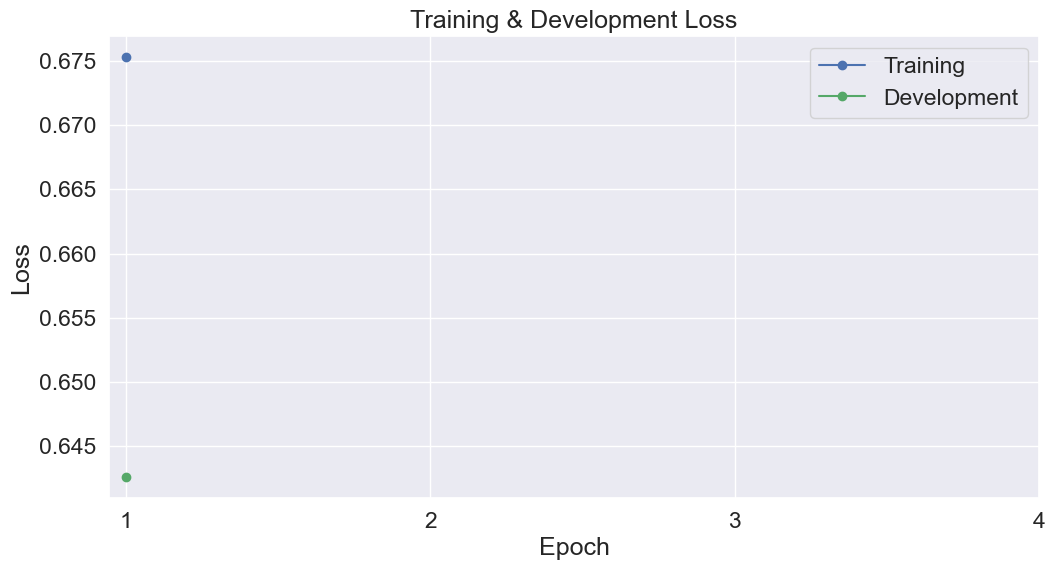

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn 사용하여 plot 생성
sns.set(style='darkgrid')

# plot 사이즈 & 폰트 사이즈 지정
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Train Loss'], 'b-o', label="Training")
plt.plot(df_stats['Dev Loss'], 'g-o', label="Development")

# Label the plot.
plt.title("Training & Development Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### Development 데이터 검증


In [ ]:
# Prediction on dev set

print('Predicting labels for {:,} dev sentences...'.format(len(input_ids_dev)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)

  dev_logits = outputs[0]

  # Move logits and labels to CPU
  dev_logits = dev_logits.to('cpu').numpy()
  label_ids = b_labels.to('cpu').numpy().astype(np.int64)
  dev_logits = dev_logits.tolist()
  label_ids = label_ids.tolist()

  # Store predictions and true labels
  predictions.append(dev_logits)
  true_labels.append(label_ids)


print("Predictions: ", predictions)
print("True_labels: ", true_labels)

print('    DONE.')

Predicting labels for 2,032 dev sentences...
Predictions:  [[[-0.316694051027298, 0.08650478720664978], [-0.5229814648628235, 0.4206664264202118], [0.377425879240036, -0.27868881821632385], [-0.530193030834198, 0.2990741729736328], [-0.6302367448806763, 0.39459511637687683], [-0.03511101007461548, -0.13629265129566193], [0.1133509948849678, -0.17944012582302094], [-0.16294093430042267, -0.024090778082609177], [-0.4827418923377991, 0.29817911982536316], [0.2943946123123169, -0.4805684983730316], [-0.6021129488945007, 0.43896061182022095], [-0.7743023037910461, 0.5124249458312988], [-0.5261939167976379, 0.35836976766586304], [-0.39190390706062317, 0.19787168502807617], [-0.39357107877731323, 0.1718222051858902], [-0.0055586774833500385, -0.240733340382576], [-0.2902618944644928, 0.09920898079872131], [-0.13675130903720856, -0.060628920793533325], [-0.2030838578939438, 0.04014681652188301], [0.01188200619071722, -0.28184518218040466], [-0.2228313535451889, 0.19302381575107574], [0.0993977

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (labels_dev.sum(), len(labels_dev), (labels_dev.sum() / len(labels_dev) * 100.0)))

Positive samples: 1071 of 2032 (52.71%)


## To Test model with test dataset

In [ ]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

matthews_set = []

# Evaluate each dev batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')
print("Len_true_labels: ", len(true_labels))

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  print(pred_labels_i)

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...
Len_true_labels:  64
[1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 0]
[0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1]
[0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0]
[0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1]
[1 1 1 0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1]
[0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1]
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0]
[1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1]
[1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0]
[1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1]
[1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1]
[1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0]
[1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0]
[0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1]
[0 0

/var/folders/b2/zwc3jd5d6wn09h5jtpfzqcqc0000gn/T/ipykernel_2087/1778854154.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


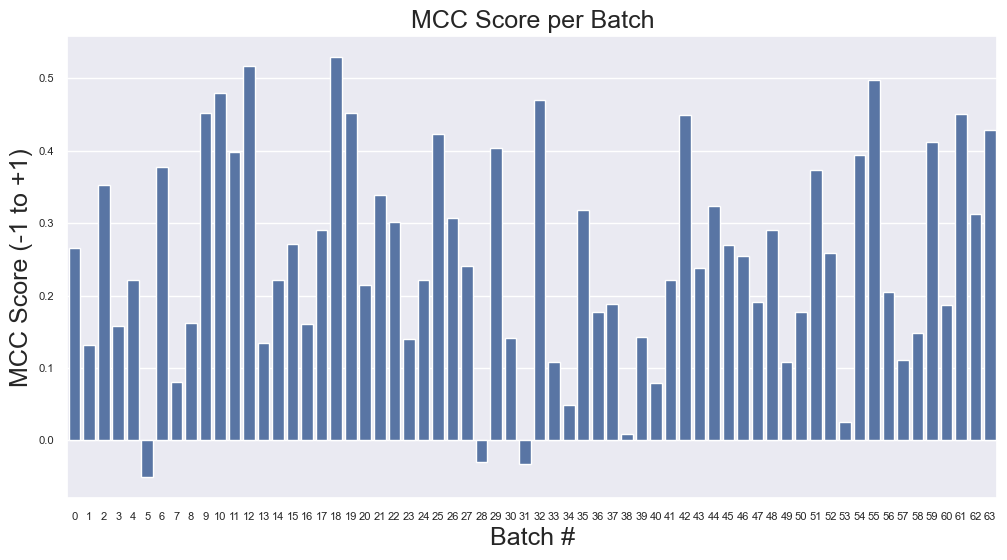

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)
print(f"First predictions {flat_predictions}")

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
print(f"Second predictions {flat_predictions}")

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

First predictions [[-0.31669405  0.08650479]
 [-0.52298146  0.42066643]
 [ 0.37742588 -0.27868882]
 ...
 [-0.34115133  0.10066893]
 [-0.32059503  0.1674536 ]
 [-0.76147956  0.52480876]]
Second predictions [1 1 0 ... 1 1 1]
Total MCC: 0.242


## To save my own model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /opt/anaconda3/envs/LLM_gramKo/model_save/


('/opt/anaconda3/envs/LLM_gramKo/model_save/tokenizer_config.json',
 '/opt/anaconda3/envs/LLM_gramKo/model_save/special_tokens_map.json',
 '/opt/anaconda3/envs/LLM_gramKo/model_save/spiece.model',
 '/opt/anaconda3/envs/LLM_gramKo/model_save/added_tokens.json')

In [ ]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


## Import my own Model

In [ ]:
# Step to use my own fine-tuned model
output_dir = './model_save/'
print(output_dir)

/opt/anaconda3/envs/LLM_gramKo/model_save/


In [ ]:
tokenizer = KoBERTTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)
print(tokenizer)
print(model_loaded)

KoBERTTokenizer(name_or_path='/opt/anaconda3/envs/LLM_gramKo/model_save/', vocab_size=8002, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}
BertForSequenceClassification(
  (bert): B

### Encode Test dataset

In [ ]:
input_ids_test = []
attention_masks_test = []

print("sentences_test:", sentences_test)

for sent in sentences_test:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 64,
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    # 인코딩된 문장들 List[input_ids_test]에 넣기 but input_ids_test은 이미
    input_ids_test.append(encoded_dict['input_ids'])
    attention_masks_test.append(encoded_dict['attention_mask'])

input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
index_test = torch.tensor(index_test)

print("Input_id_test: ", input_ids_test)
print("Attention_mask_test: ", attention_masks_test)
print("Index_test: ", index_test)

sentences_test: ['나는 철수에게 공을 던져다 주었다.' '먹은 것을 다 소화시켜야 한다.' '그가 노래를 부르고는 내가 피아노를 쳤다.' ...
 '그는 나를 바보 여긴다.' '수호는 모든 일에 전혀 무감각하다.' '나는 할아버지가 제일 무서우시다.']
Input_id_test:  tensor([[   2, 1375, 4473,  ...,    1,    1,    1],
        [   2, 2010, 7086,  ...,    1,    1,    1],
        [   2, 1186, 1479,  ...,    1,    1,    1],
        ...,
        [   2, 1191, 1370,  ...,    1,    1,    1],
        [   2, 2872, 7926,  ...,    1,    1,    1],
        [   2, 1375, 4977,  ...,    1,    1,    1]])
Attention_mask_test:  tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Index_test:  tensor([   1,    2,    3,  ..., 1058, 1059, 1060])


In [ ]:
model_loaded = model_loaded.to(device)
input_ids_test = input_ids_test.to(device)
attention_masks_test = attention_masks_test.to(device)

In [ ]:
with torch.no_grad():
  # Forward pass, calculate logit predictions
  outputs = model_loaded(input_ids_test, token_type_ids=None, attention_mask=attention_masks_test)

test_logits = outputs[0]
test_logits = test_logits.detach().cpu().numpy()
test_logits = np.argmax(test_logits, axis=1).flatten()
labels_test = []
for i in range(len(test_logits)):
    index = test_logits[i]
    if index == 1:
      labels_test.append(1)
      # print("1(True)")
    else:
      labels_test.append(0)
      # print("0(False)")
result = labels_test
print(result)

[1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 

## To Convert result to contest format

In [ ]:
import json

dict_result = [{"idx" : idx, "label" : data} for idx, data in enumerate(result)]
with open("./dataset/COLA_Test.json", "w") as json_file:
    json_result = {"cola" : dict_result}
    json.dump(json_result, json_file)

In [ ]:
with open('./dataset/COLA_Test.json') as json_file:
    COLA = json.load(json_file)
    print(COLA)